# Analysis of  StarTracker Pointing - Repeatability 
## Second Set - 16th/17th March

Full test description at: https://sitcomtn-063.lsst.io/

In this notebook, we quantify the telescope repeatability of a target after settle to a coordinate.

For this:
1. We compute the standard deviation of $\delta ra \text{, } \delta dec$
2. Does the variance depends on $ra, dec$?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [3]:
def get_groups(df):
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    groups = np.zeros(ra.size, dtype=int)
    snakes = np.zeros(ra.size, dtype=int)
    
    diffRa = np.diff(ra)
    diffDec = np.diff(dec)
    dPnt = np.hypot(diffDec, diffRa)
    
    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>1/60): counter += 1    
        groups[i+1] = counter

    df['groups'] = groups    
    print('Number of groups:%i'%np.unique(groups).size)
    return df

In [4]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(x)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return np.append(coefs, np.sqrt(cov[1,1]))

def get_residual(df):    
    groups = df['groups'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        #base_ra[ix] = ra[ix][0]
        #base_dec[ix] = dec[ix][0]
        
        base_ra[ix] = np.median(ra[ix])
        base_dec[ix] = np.median(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

## Night: 17th March

Brian told me they took some snake data this night. According to the night log the sequences 292-858 should be this data.

In [5]:
# read in dataframe
today = '2023-03-17'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [6]:
df

,Exposure Time wide,MJD wide,Ra wide,Dec wide,Alt wide,Az wide,nSources wide,nSources filtered wide,Exposure Time,MJD,...,Delta Ra Arcsec,Delta Dec Arcsec,Delta Alt Arcsec,Delta Az Arcsec,Delta Rot Arcsec,RMS scatter arcsec,RMS scatter pixels,UTC,UTC wide,seq_num
11,1.0,60021.047024,107.285242,-70.014000,49.401269,187.350812,35.0,28.0,4.0,60021.043178,...,47.134810,27.180532,21.563468,-24.067907,219214.040807,1.474173,1.023409,2023-03-17 01:02:10,2023-03-17 01:07:42,11
12,5.0,60021.047765,107.285220,-70.013998,49.371421,187.483365,3628.0,200.0,4.0,60021.047759,...,46.183479,24.897977,19.944510,-23.824475,227169.517189,1.445945,1.004073,2023-03-17 01:08:46,2023-03-17 01:08:46,12
14,5.0,60021.089153,107.130861,-70.497386,46.506978,193.791550,2451.0,200.0,4.0,60021.089148,...,81.927888,22.190406,28.562817,-27.327036,295235.567813,1.455512,1.010514,2023-03-17 02:08:22,2023-03-17 02:08:22,14
16,5.0,60021.099732,106.314011,-70.888731,45.210330,195.091144,3388.0,200.0,4.0,60021.099726,...,97.632086,17.641537,30.012986,-32.208299,314454.286460,2.261735,1.570042,2023-03-17 02:23:36,2023-03-17 02:23:36,16
17,5.0,60021.101324,107.952328,-70.114480,46.019253,195.468020,3587.0,200.0,4.0,60021.101318,...,90.645080,20.782571,31.519690,-28.963642,311631.488335,1.423778,0.988687,2023-03-17 02:25:53,2023-03-17 02:25:54,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,5.0,60021.408739,208.563206,20.039525,24.916861,314.898522,145.0,116.0,4.0,60021.408733,...,61.723962,-69.847611,106.776869,-1.113289,661295.157663,1.453536,1.009202,2023-03-17 09:48:34,2023-03-17 09:48:35,854
855,5.0,60021.408842,208.563286,20.039525,24.894167,314.869344,151.0,121.0,4.0,60021.408836,...,62.067716,-70.276788,107.542714,-0.892559,661195.442676,1.469472,1.020123,2023-03-17 09:48:43,2023-03-17 09:48:43,855
856,5.0,60021.409087,207.062172,23.242855,21.501047,315.919745,212.0,170.0,4.0,60021.409082,...,75.337380,-82.555721,124.346527,-0.372154,660571.868042,1.572268,1.090930,2023-03-17 09:49:04,2023-03-17 09:49:05,856
857,5.0,60021.409190,207.062265,23.242901,21.478822,315.892165,251.0,200.0,4.0,60021.409184,...,75.536825,-83.082195,124.494013,-1.089922,660462.056973,1.474112,1.022858,2023-03-17 09:49:13,2023-03-17 09:49:14,857


In [7]:
sequences = [ [292,858] ]
indices = np.empty((0,), dtype=int)
for i0, ie in sequences:
    _indices = np.arange(np.where(df['seq_num']==i0)[0][0], np.where(df['seq_num']==ie)[0][0], 1)
    indices = np.append(indices, _indices)

In [8]:
# selection of the sequences
data = df.iloc[indices].reset_index() 
print(('Positions for ' + str(data.seq_num.iloc[0]) + ' to ' + str(data.seq_num.iloc[-1])))
data = get_groups(data)

Positions for 292 to 857
Number of groups:183


In [9]:
# check groups
# each group should have 3 exposures
_, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
counts

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2])

In [10]:
gids, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
is_group = counts==3
ngroups = np.count_nonzero(is_group)
print('Number of Groups w/ 3 exposures: %i'%ngroups)

Number of Groups w/ 3 exposures: 181


In [11]:
# filter
mask = np.in1d(data['groups'].to_numpy(), gids[is_group])
data = data.iloc[mask].copy()

In [12]:
sids = np.arange(1, ngroups/11, 1, dtype=int)
snakes = (int(ngroups/11)+1)*np.ones_like(data['groups'].to_numpy())

snakes[:33*len(sids)] = np.repeat(sids, 33)

data['snakes'] = snakes

In [13]:
# check groups
# each group should have 3 exposures
_, sids, counts = np.unique(data['snakes'].to_numpy(), return_index=True, return_counts=True)
counts

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 15])

## Compute Residuals

In [14]:
res_ra, res_dec, base_ra, base_dec = get_residual(data)

snakes = data['snakes'].to_numpy()
keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]
keys[-15]

array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

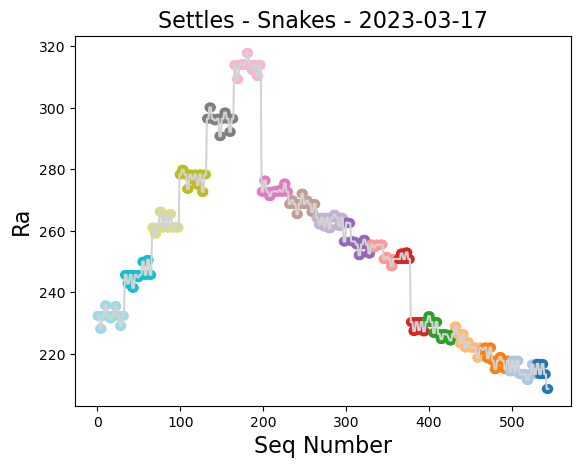

In [15]:
snake_id = 26
# ix = keys[snake_id]
ix = np.arange(0,len(data),1)
data['Calculated Ra wide'].iloc[ix].plot(color='lightgray')
plt.scatter(data.iloc[ix].index, data['Calculated Ra wide'].iloc[ix], 
            c=data['snakes'].iloc[ix], cmap='tab20_r')

plt.title('Settles - Snakes - %s'%today, fontsize=16)
plt.ylabel('Ra', fontsize=16)
plt.xlabel('Seq Number', fontsize=16)
plt.savefig('figures/pointing_ra_%s.png'%today,dpi=100)

For each group (setlle point), I subtract the median (RA,DEC). The residuals are basically the telescope jitter.

In [16]:
base_alt = data['Calculated Alt wide'].to_numpy()
base_az = data['Calculated Az wide'].to_numpy()
snakes = data['snakes'].to_numpy()

# base_az = np.where(base_az>180, 180-base_az, base_az)
# base_ra = np.where(base_ra>180, 180-base_ra, base_ra)

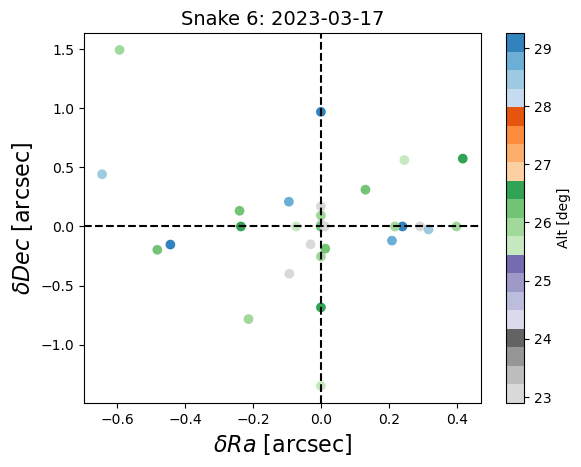

In [19]:
snake_id = 6
ix = keys[snake_id]
plt.scatter(res_ra[ix], res_dec[ix], c=base_alt[ix],cmap='tab20c_r')
plt.axvline(0,color='k',ls='--')
plt.axhline(0,color='k',ls='--')
plt.title('Snake %i: %s'%(snake_id,today), fontsize=14)
plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
plt.colorbar(label='Alt [deg]')
plt.savefig('figures/residual_radec_snake%i_%s.png'%(snake_id, today),dpi=100)

We see a typical jitter amplitude of $0.5$ arcsec with some outliers.

In [20]:
def get_sigma_68(x):
    p16, p84 = np.nanpercentile(x, [16,84])
    return (p84-p16)/2.

def get_jitter(ra,dec):
    jra = get_sigma_68(ra)
    jdec = get_sigma_68(dec)
    return np.array([jra, jdec, np.hypot(jra,jdec)])

In [21]:
# Now I will compute the standard deviation (\sigma_{68}) for each snake

stds = []
for ix in keys:
    stds.append(get_jitter(res_ra[ix],res_dec[ix]))
stds = np.array(stds)

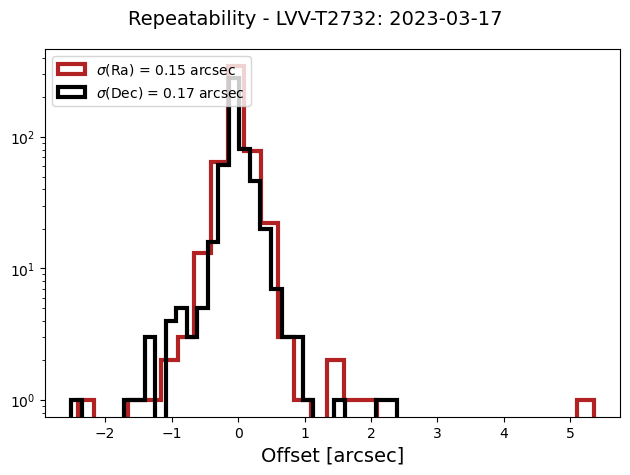

In [22]:
jra = get_sigma_68(res_ra)
jdec = get_sigma_68(res_dec)

_ = plt.hist(res_ra, bins=31, color='firebrick', histtype='step', lw=3, label='$\sigma$(Ra) = %.2f arcsec'%jra)
_ = plt.hist(res_dec, bins=31, color='k', histtype='step', lw=3, label='$\sigma$(Dec) = %.2f arcsec'%jdec)
plt.yscale('log')
plt.legend(loc=2)
plt.xlabel('Offset [arcsec]', fontsize=14)
plt.suptitle('Repeatability - LVV-T2732: %s'%today,fontsize=14)
plt.tight_layout()
plt.savefig('figures/radec_residual_histogram_%s.png'%today,dpi=100)

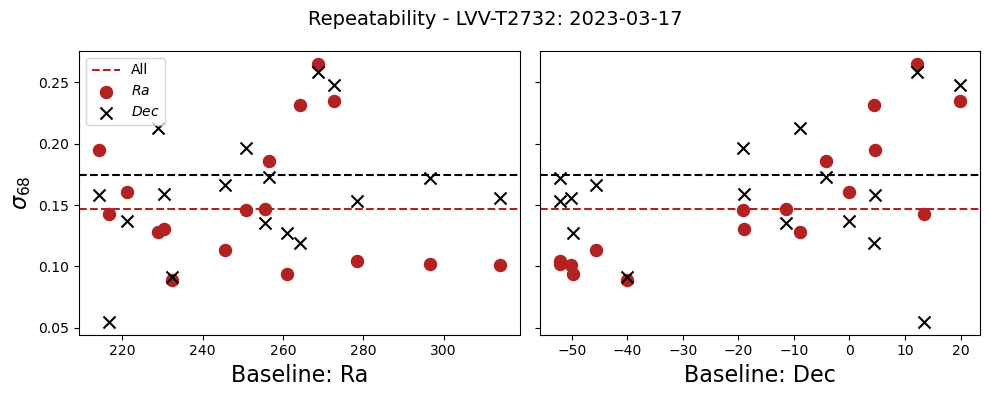

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax2.axhline(jra, c='firebrick', ls='--')
ax2.axhline(jdec, c='k', ls='--')

ax1.axhline(jra, c='firebrick', ls='--',label='All')
ax1.axhline(jdec, c='k', ls='--')

ax1.scatter(base_ra[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_dec[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_ra[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_dec[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax1.errorbar(base_ra[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')
# ax2.errorbar(base_dec[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Ra',fontsize=16)
ax2.set_xlabel('Baseline: Dec',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: %s'%today,fontsize=14)
fig.tight_layout()

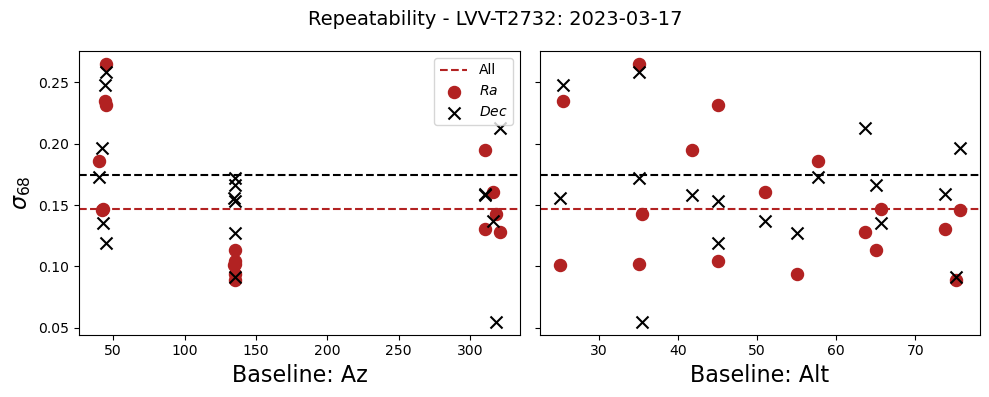

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax2.axhline(jra, c='firebrick', ls='--')
ax2.axhline(jdec, c='k', ls='--')

ax1.axhline(jra, c='firebrick', ls='--',label='All')
ax1.axhline(jdec, c='k', ls='--')

ax1.scatter(base_az[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_alt[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_az[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_alt[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=0)
# ax2.legend(loc=1)

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Az',fontsize=16)
ax2.set_xlabel('Baseline: Alt',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: %s'%today,fontsize=14)
fig.tight_layout()
plt.savefig('figures/scatter_radec_azalt_%s.png'%today,dpi=100)